In [ ]:
# window range, skull masking 등 전처리 비교 시각화

In [ ]:
!rm -rf /content/StrokeSegmentation

In [ ]:
# 구글 드라이브에 마운트하기 전에 실행!!! (master, main 푸시 구분해줘야함)
!git clone -b master https://github.com/MANDUnoko/StrokeSegmentation.git

Cloning into 'StrokeSegmentation'...
remote: Enumerating objects: 4792, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4792 (delta 0), reused 2 (delta 0), pack-reused 4786 (from 2)
Receiving objects: 100% (4792/4792), 869.76 MiB | 34.64 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Updating files: 100% (4765/4765), done.


In [ ]:
import os
import sys

def add_module_path(target_folder_name):
    """
    Colab 환경에서 특정 폴더(예: 'preprocessing')를 포함한 경로를 찾아 sys.path에 자동 추가해주는 함수
    """
    for root, dirs, files in os.walk("/content"):
        if target_folder_name in dirs:
            module_path = os.path.abspath(root)
            if module_path not in sys.path:
                sys.path.append(module_path)
                print(f"추가됨: {module_path}")
            else:
                print(f"이미 등록됨: {module_path}")
            return module_path
    raise FileNotFoundError(f"'{target_folder_name}' 폴더를 /content 하위에서 찾을 수 없습니다.")

# 예: 'preprocessing' 폴더 자동 탐색 후 import
add_module_path("preprocessing")

추가됨: /content/StrokeSegmentation


'/content/StrokeSegmentation'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pydicom

In [ ]:
import matplotlib.pyplot as plt
from pydicom import dcmread
import nibabel as nib
import numpy as np
import cv2
import os
import torch
import os

from preprocessing.hu_utils import dicom_to_hu
from preprocessing.brain_mask import apply_brain_mask
from preprocessing.windowing import window_image, normalize_image
from preprocessing.utils import resize_image, resize_volume
from scripts.preprocess import preprocess_ct_with_mask, preprocess_nii_with_mask, save_preprocessed

In [ ]:
# dicom 파일

In [ ]:
# 1. Load
dicom_path = "./data/raw/Bleeding/DICOM/10002.dcm"
mask_path = "./data/raw/Bleeding/PNG/10002.png"

ds = dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)
mask = cv2.imread(mask_path, 0) / 255.0  # mask는 PNG인 경우

In [ ]:
# 2. Process 단계별 저장
hu = dicom_to_hu(ds)
stripped = apply_brain_mask(hu, mask)
windowed = window_image(stripped, -40, 100)
normalized = normalize_image(windowed, -40, 100)
resized = resize_image(normalized, (512, 512))

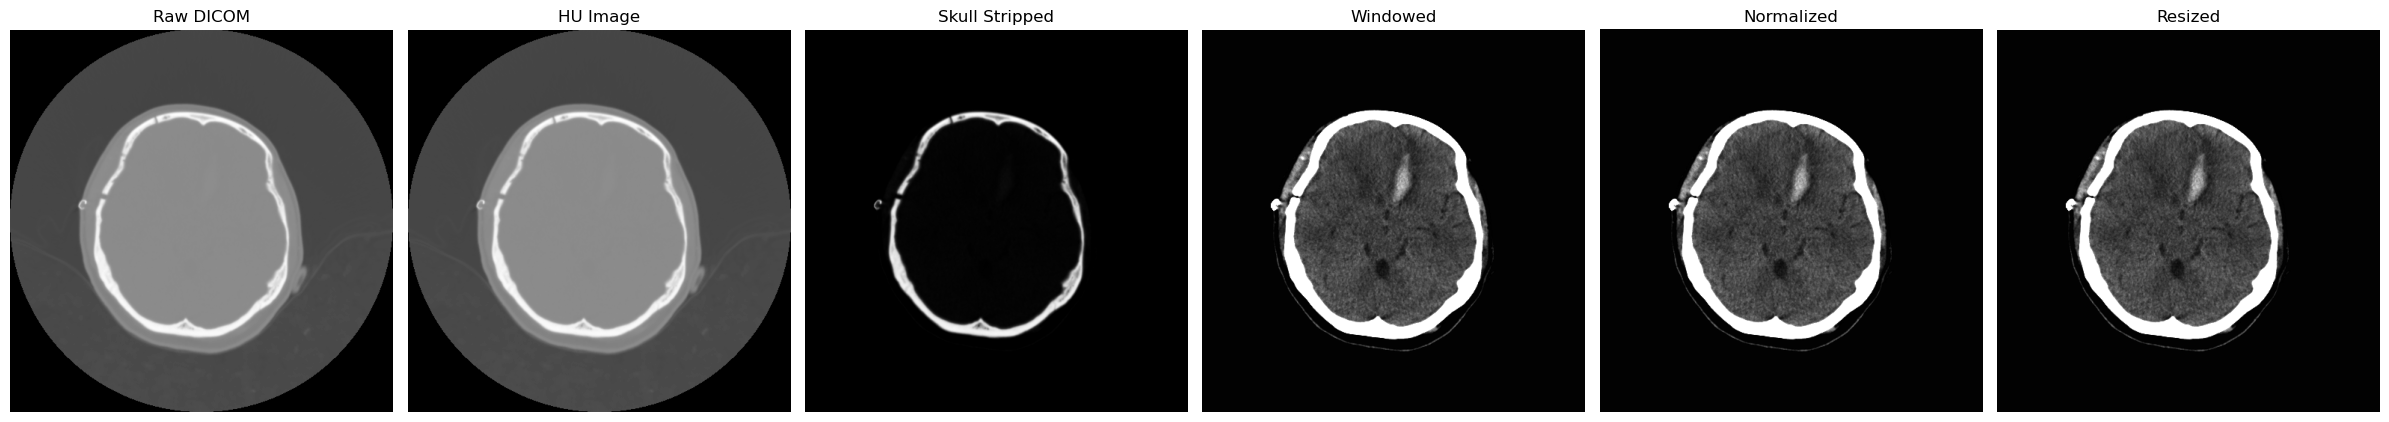

In [ ]:
# 3. 시각화
fig, axs = plt.subplots(1, 6, figsize=(24, 5))
titles = ["Raw DICOM", "HU Image", "Skull Stripped", "Windowed", "Normalized", "Resized"]
images = [image, hu, stripped, windowed, normalized, resized]

for i in range(6):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 실제 실행(시각화 없이 바로 진행)
dicom_dir = "data/raw/Bleeding/DICOM"
mask_dir = "data/raw/Bleeding/PNG"
output_dir = "data/processed/train"

for filename in os.listdir(dicom_dir):
    if not filename.lower().endswith(".dcm"):
        continue

    case_id = os.path.splitext(filename)[0]
    dicom_path = os.path.join(dicom_dir, filename)
    mask_path = os.path.join(mask_dir, f"{case_id}.png")
    save_path = os.path.join(output_dir, f"{case_id}.pt")

    if not os.path.exists(mask_path):
        print(f"마스크 없음: {case_id}")
        continue

    try:
        ds = dcmread(dicom_path)
        mask = cv2.imread(mask_path, 0) / 255.0

        assert ds.pixel_array.shape == mask.shape, f"Shape mismatch: {case_id}"

        image = preprocess_ct_with_mask(ds, mask)
        save_preprocessed(image, save_path)

        print(f"저장 완료: {case_id}")

    except Exception as e:
        print(f"오류 발생: {case_id} | {e}")

In [ ]:
# 저장 확인 (pt는 전처리된 CT 이미지(마스크 정보 없음))
tensor = torch.load("data/processed/train/sample.pt")
print(tensor.shape, tensor.dtype)  # → torch.Size([1, 512, 512]) torch.float32

# nii 파일

In [ ]:
# ================================
# 파일 로드
# ================================
volume_path = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data/raw/Bleeding/ct_scans/049.nii.gz"
brain_mask_path = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data/raw/Bleeding/brain_masks/049_bet.nii.gz"

volume_nii = nib.load(volume_path)
mask_nii = nib.load(brain_mask_path)

volume = volume_nii.get_fdata()
brain_mask = mask_nii.get_fdata()

print("Volume shape:", volume.shape)
print("Brain mask shape:", brain_mask.shape)

Volume shape: (512, 512, 39)
Brain mask shape: (512, 512, 39)


In [ ]:
# ================================
# 전처리 단계별 저장
# ================================
# hu_image = dicom_to_hu(volume) => dicom 은 hu 처리가 필요하지만 nii는 hu 자체라 필요없음
hu_image = volume.copy()
stripped_image = apply_brain_mask(hu_image, brain_mask)
windowed_image = window_image(stripped_image, 40 - 40, 40 + 40)  # WL=40, WW=80
normalized_image = normalize_image(windowed_image, -40, 100)
# resized_image = resize_image(normalized_image, (512, 512)) nii 파일은 volumn 단위로 resize
resized_volume = resize_volume(normalized_image, size=(512, 512))

In [ ]:
def visualize_images(volume, brain_mask, hu_image, stripped_image, windowed_image, normalized_image, resized_volumn):
    mid_idx = volume.shape[2] // 2

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 4, 1)
    plt.title("Raw DICOM")
    plt.imshow(volume[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 2)
    plt.title("Brain Mask")
    plt.imshow(brain_mask[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 3)
    plt.title("Skull Stripped")
    plt.imshow(stripped_image[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 4)
    plt.title("Windowed")
    plt.imshow(windowed_image[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 5)
    plt.title("Normalized")
    plt.imshow(normalized_image[:, :, mid_idx], cmap="gray")

    plt.subplot(2, 4, 6)
    plt.title("Resized")

    if resized_volume.ndim == 3:
        mid_idx = resized_volume.shape[2] // 2
        plt.imshow(resized_volume[:, :, mid_idx], cmap="gray")
    else:
        plt.imshow(resized_volume, cmap="gray")

    plt.tight_layout()
    plt.show()

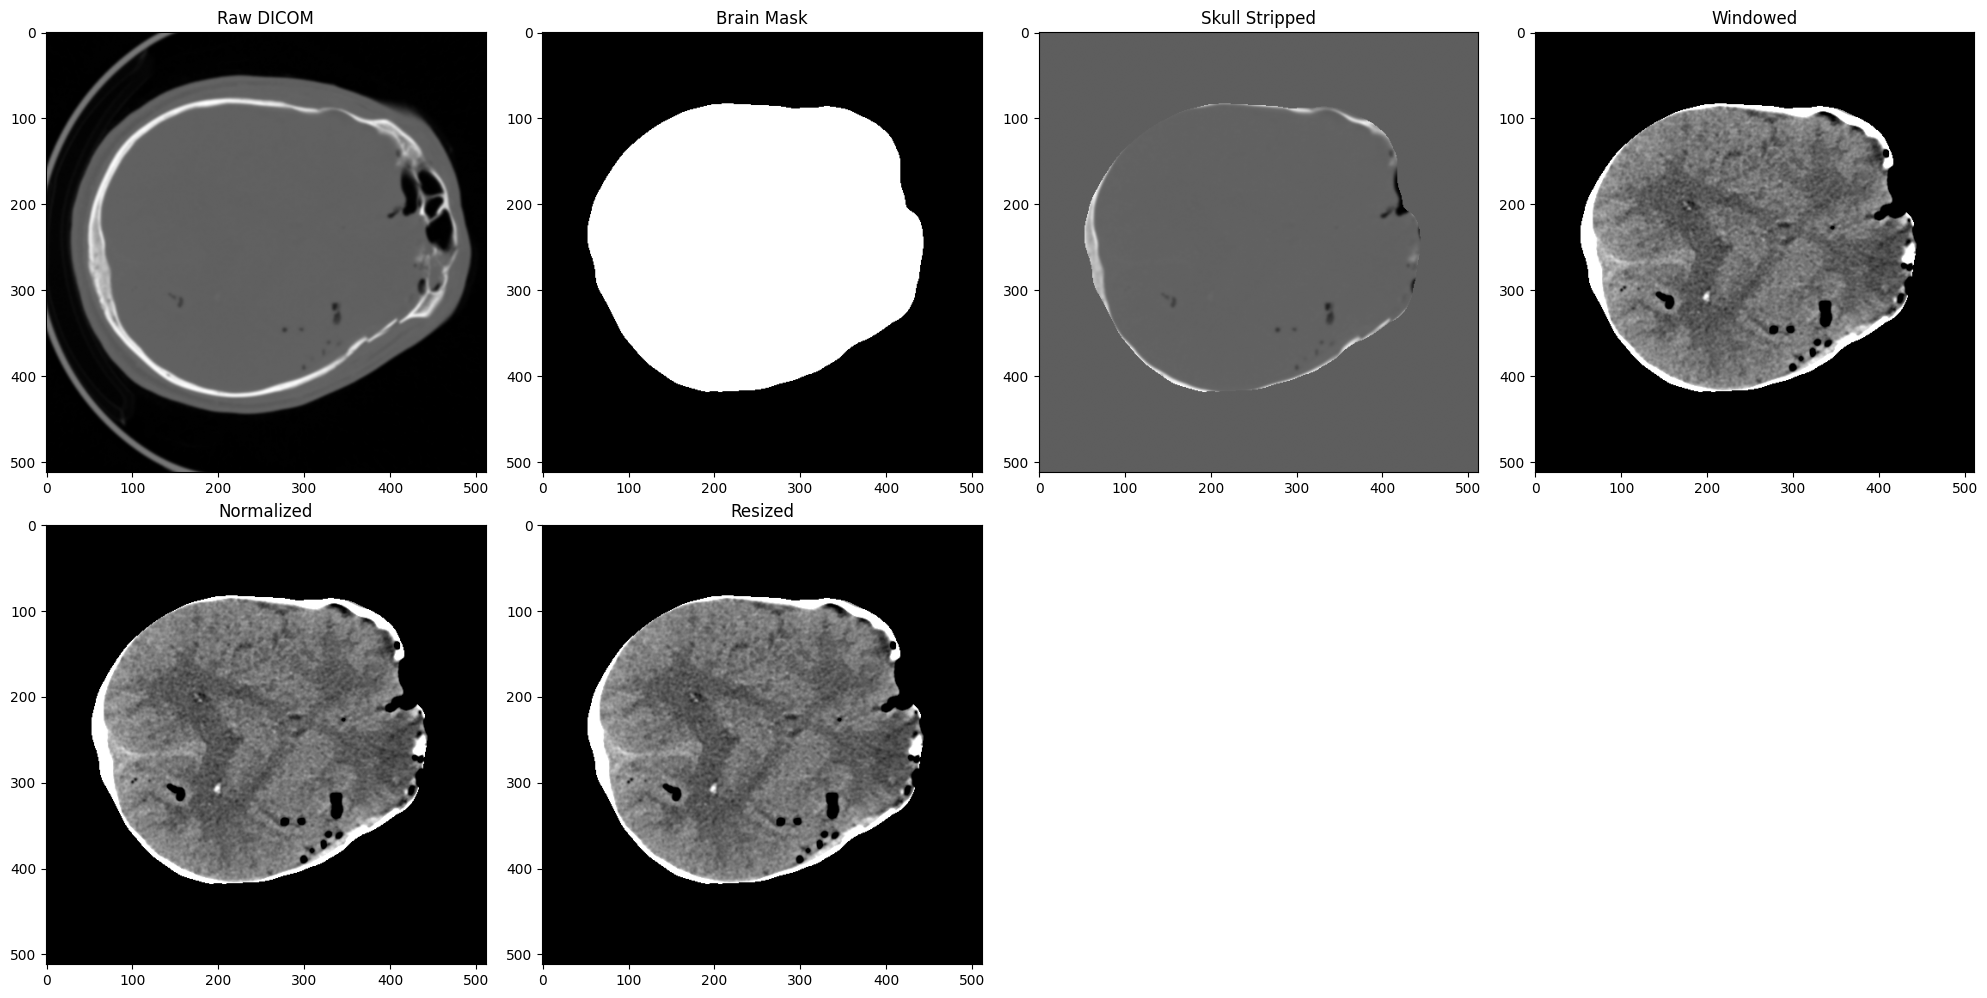

In [ ]:
visualize_images(volume, brain_mask, hu_image, stripped_image, windowed_image, normalized_image, resized_volume)

In [ ]:
# 같이 학습에 사용할 마스크 크기 확인
mask_nii = nib.load('/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/2차 시도/data/raw/Bleeding/masks/049.nii')
mask = mask_nii.get_fdata()
print(mask.shape)
print(mask.dtype)

(512, 512, 39)
float64


In [ ]:
# 마스크가 있는 slice 찾기
for i in range(mask.shape[2]):
    if np.max(mask[:, :, i]) > 0:
        print(f"Nonzero mask found at slice {i}")

Nonzero mask found at slice 13
Nonzero mask found at slice 14
Nonzero mask found at slice 15
Nonzero mask found at slice 16
Nonzero mask found at slice 19
Nonzero mask found at slice 20
Nonzero mask found at slice 21
Nonzero mask found at slice 22
Nonzero mask found at slice 26


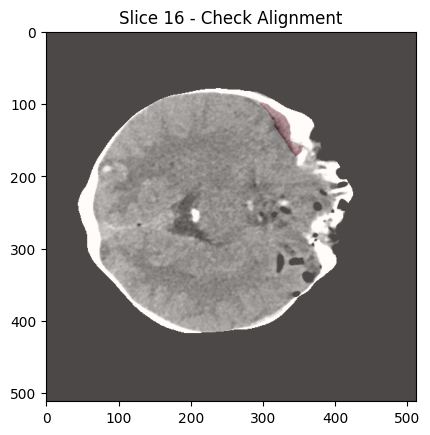

In [ ]:
# 잘겹쳐지는지 확인
slice_idx = 16

vmin = np.min(resized_volume)
vmax = np.max(resized_volume)

# 명확한 contrast로 고정 시각화
plt.imshow(slice_img, cmap="gray", vmin=slice_img.min(), vmax=slice_img.max())
plt.imshow(mask[:, :, slice_idx], cmap='Reds', alpha=0.3)
plt.title(f"Slice {slice_idx} - Check Alignment")
plt.show()

In [ ]:
# 마스크랑 원본의 뇌 위치가 일치하는지 확인
print("Volume shape:", resized_volume.shape)
print("Mask shape:  ", mask.shape)

# 각 축의 평균값 비교해보기
print("Volume slice mean:", np.mean(resized_volume[:, :, slice_idx]))
print("Mask slice mean:  ", np.mean(mask[:, :, slice_idx]))  # 안 맞을 수도 있음
print("Mask slice mean (alt axis):", np.mean(mask[slice_idx, :, :]))

Volume shape: (512, 512, 39)
Mask shape:   (512, 512, 39)
Volume slice mean: 0.3866181506157934
Mask slice mean:   1.0992050168339151
Mask slice mean (alt axis): 0.0


In [ ]:
# ================================
# 전체 슬라이스 전처리 & 저장
# ================================
def process_directory(nii_dir, mask_dir, brain_mask_dir, output_dir):
    for fname in os.listdir(nii_dir):
        if not fname.lower().endswith(('.nii', '.nii.gz')):
            continue  # NIfTI 파일만 처리

        case_id = os.path.splitext(fname)[0]
        nii_path = os.path.join(nii_dir, fname)  # NIfTI 파일 경로
        mask_path = os.path.join(mask_dir, f"{case_id}.png")  # 병변 마스크
        brain_mask_path = os.path.join(brain_mask_dir, f"{case_id}.nii.gz")  # 뇌 마스크

        # 병변 마스크 및 뇌 마스크 파일 존재 확인
        if not os.path.exists(mask_path):
            print(f"병변 마스크 없음: {case_id}")
            continue
        if not os.path.exists(brain_mask_path):
            print(f"뇌 마스크 없음: {case_id}")
            continue

        try:
            # NIfTI 파일 읽기
            nii_data = nib.load(nii_path)
            volume = nii_data.get_fdata()

            # 병변 마스크 읽기
            mask = cv2.imread(mask_path, 0) / 255.0  # 병변 마스크를 0-1 범위로 읽기

            # 뇌 마스크 읽기
            brain_mask_nii = nib.load(brain_mask_path)
            brain_mask = brain_mask_nii.get_fdata()

            # 이미지 크기 일치 확인
            assert volume.shape == mask.shape, f"Shape mismatch: {case_id}"
            assert volume.shape == brain_mask.shape, f"Brain mask shape mismatch: {case_id}"

            # 전처리
            image = preprocess_nii_with_mask(volume, brain_mask)

            # 저장 경로 설정
            save_path = os.path.join(output_dir, f"{case_id}.pt")
            save_preprocessed(image, save_path)

            print(f"저장 완료: {case_id}")

        except Exception as e:
            print(f"오류 발생: {case_id} | {e}")  # 오류 메시지 출력


In [ ]:
nii_dir = "data/raw/Bleeding/NIfTI"  # NIfTI 파일이 저장된 폴더 경로
mask_dir = "data/raw/Bleeding/PNG"  # 병변 마스크 파일 경로
brain_mask_dir = "data/raw/Bleeding/Brain_Masks"  # 뇌 마스크 파일 경로
output_dir = "data/processed/train"  # 전처리된 결과 저장 경로

process_directory(nii_dir, mask_dir, brain_mask_dir, output_dir)

In [ ]:
# 저장 확인 (pt는 전처리된 CT 이미지(마스크 정보 없음))
tensor = torch.load("data/processed/train/sample.pt")
print(tensor.shape, tensor.dtype)  # → torch.Size([1, 512, 512]) torch.float32